In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import pk_tools as pk
import fg_tools as fg

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

### Loading data:

In [3]:
FGnopol_data = np.load('../Data/dT_HI+noise+FGnopol_Stripe82_15mBeam_unsmoothednoise.npy')
HI_data = np.load('../Data/dT_HI_smoothed.npy')
noise_data = np.load('../Data/dT_noise.npy')

Perform PCA removal of data, to compare with GPR:

In [4]:
pca_res_nopol3 = fg.PCAclean(FGnopol_data, N_FG=3)[0]

Frequency range of data:

In [5]:
df = 1 # frequency resolution of data (MHz)
vmin = 899 # min frequency (MHz)
vmax = 1184 # max frequency (MHz)
freqs = np.arange(vmin, vmax, df)

### Running GPR

In [6]:
# Choose your kernels, one for FG and one for HI signal
kern = GPy.kern.RBF(1) + GPy.kern.Exponential(1)
# run GPR and obtain residuals
gpr_res, model = fg.GPRclean(FGnopol_data, freqs, kern, num_restarts=10, NprePCA=1)

Optimization restart 1/10, f = -21870054.662858825
Optimization restart 2/10, f = -21641323.946849376
Optimization restart 3/10, f = -21641323.946762122
Optimization restart 4/10, f = -16123995.19261555
Optimization restart 5/10, f = -21841955.02520945
Optimization restart 6/10, f = -21641325.58159126
Optimization restart 7/10, f = -21961841.968554728


 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /opt/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/GPy/kern/src/stationary.py:213: RuntimeWarning:invalid value encountered in multiply


Optimization restart 8/10, f = -21639476.224656038
Optimization restart 9/10, f = -17767787.53561497
Optimization restart 10/10, f = -21963052.048150655


In [7]:
model

GP_regression.,value,constraints,priors
sum.rbf.variance,568.7335173622957,+ve,
sum.rbf.lengthscale,285.52930962207523,+ve,
sum.Exponential.variance,0.0010777568135825367,+ve,
sum.Exponential.lengthscale,3.5647862557700023,+ve,
Gaussian_noise.variance,0.0038115352618359574,+ve,


### Plot power spectra

In [8]:
# Dimension of data cube:
lx,ly,lz = 1000,1000, 924.78 #Mpc/h
nx,ny,nz = 256, 256, 285
# Measure the auto-power spectrum, with noise:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 1
dk = 2*kmin
nkbin = int((kmax-kmin)/dk)
kbins = np.arange(kmin,kmax,dk)
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)
# weighting and window function:
w = W = np.ones((nx,ny,nz))

In [9]:
HIpk = pk.getpk(HI_data+noise_data,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
GPRpk = pk.getpk(gpr_res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
PCApk_3 = pk.getpk(pca_res_nopol3,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

Text(0.5, 0, 'k [$h$/Mpc]')

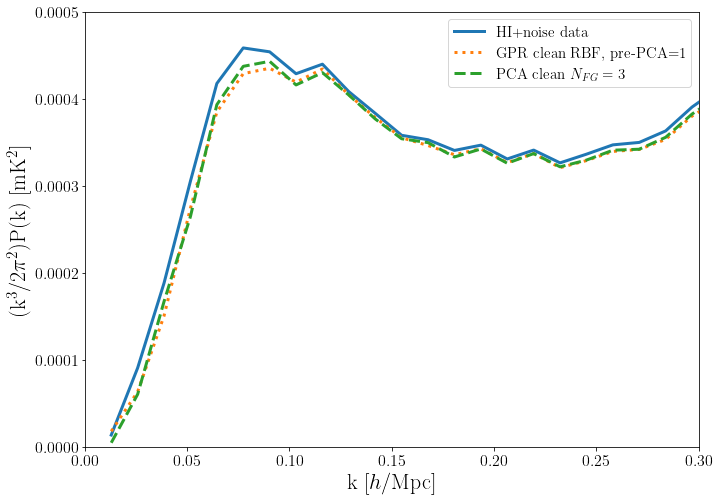

In [10]:
plt.figure(figsize=(11,8))

plt.plot(k, (k*k*k*HIpk)/(2*np.pi*np.pi),ls='solid', lw=3, label = r'HI+noise data')
plt.plot(k, (k*k*k*GPRpk)/(2*np.pi*np.pi),ls='dotted', lw=3, label = r'GPR clean RBF, pre-PCA=1')
plt.plot(k, (k*k*k*PCApk_3)/(2*np.pi*np.pi),ls='dashed', lw=3, label = r'PCA clean $N_{FG}=3$')

plt.legend(fontsize=15)
plt.xlim(0,0.3)
plt.ylim(0,0.0005)
plt.ylabel('(k$^3$/2$\pi^2$)P(k) [mK$^2$]', fontsize=22)
plt.xlabel('k [$h$/Mpc]', fontsize=22)

Text(0, 0.5, '\\% difference from true P(k)')

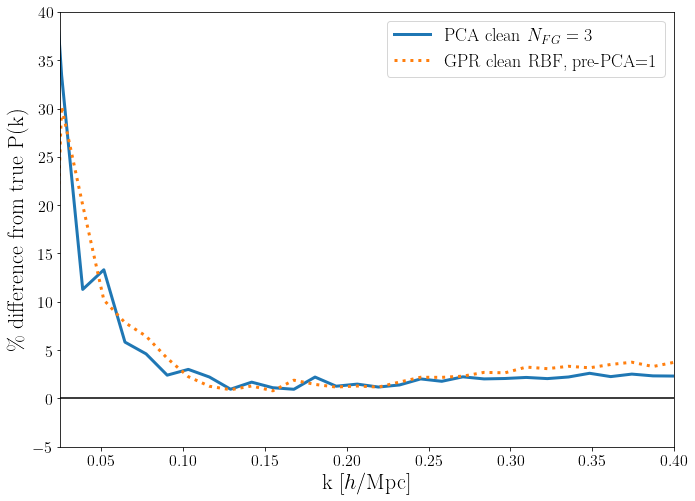

In [11]:
plt.figure(figsize=(11,8))

plt.plot(k, 100*(HIpk-PCApk_3)/HIpk, lw=3, label=r'PCA clean $N_{FG}=3$')
plt.plot(k, 100*(HIpk-GPRpk)/HIpk, lw=3,ls='dotted', label=r'GPR clean RBF, pre-PCA=1')
plt.axhline(0, c='k')

plt.xlim(0.025,0.4)
plt.ylim(-100*0.05, 100*0.4)
plt.legend(fontsize=18)
plt.xlabel('k [$h$/Mpc]', fontsize=22)
plt.ylabel('\% difference from true P(k)', fontsize=22)
